## 1.Dynamic Network

In [16]:
import pandas as pd # type: ignore

all_books = pd.read_csv("results/all_books.csv")

In [17]:
import networkx as nx

# 初始化存储所有图的字典
book_graphs = {}

# 为每本书单独创建一个图
for book_id in all_books['book'].unique():
    # 获取当前书的数据
    book_data = all_books[all_books['book'] == book_id]
    
    # 创建图对象
    G = nx.Graph()
    for _, row in book_data.iterrows():
        # 添加边并设置权重
        G.add_edge(row['Source'], row['Target'], weight=row['weight'])
    
    # 存储图
    book_graphs[book_id] = G

# 检查结果
for book_id, G in book_graphs.items():
    print(f"Book {book_id}: Nodes={G.number_of_nodes()}, Edges={G.number_of_edges()}")


Book 1: Nodes=187, Edges=684
Book 2: Nodes=259, Edges=775
Book 3: Nodes=303, Edges=1008
Book 4: Nodes=274, Edges=682
Book 5: Nodes=317, Edges=760


## 2. Community Transfer

In [18]:
import pandas as pd
import networkx as nx

# 读取社区数据
community_df = pd.read_csv("results/community_results.csv")

# 过滤掉节点数少于 min_members 的社区
min_members = 5
community_df = community_df.groupby(['Book', 'Community']).filter(lambda x: len(x) >= min_members)

# 计算每个社区中最重要角色的名字和成员个数
community_leaders = {}

for book_id in community_df['Book'].unique():
    # 获取当前书的社区数据
    book_community_data = community_df[community_df['Book'] == book_id]
    
    # 获取当前书的图
    G = book_graphs[book_id]
    
    # 计算每个社区中最重要角色的名字和成员个数
    for community in book_community_data['Community'].unique():
        # 获取当前社区的节点
        community_nodes = book_community_data[book_community_data['Community'] == community]['Node']
        
        # 计算每个节点的度中心性
        centrality = nx.degree_centrality(G)
        
        # 找到度中心性最高的节点
        leader = max(community_nodes, key=lambda node: centrality.get(node, 0))
        
        # 存储结果
        community_leaders[(book_id, community)] = leader
        
# 显示结果
for (book_id, community), leader in community_leaders.items():
    print(f"Book {book_id}, Community {community}: Leader={leader}")
        

Book 1, Community 7: Leader=Tyrion-Lannister
Book 1, Community 1: Leader=Daenerys-Targaryen
Book 1, Community 2: Leader=Eddard-Stark
Book 1, Community 3: Leader=Jon-Snow
Book 1, Community 5: Leader=Sansa-Stark
Book 1, Community 6: Leader=Robb-Stark
Book 2, Community 1: Leader=Arya-Stark
Book 2, Community 0: Leader=Tyrion-Lannister
Book 2, Community 3: Leader=Jon-Snow
Book 2, Community 4: Leader=Theon-Greyjoy
Book 2, Community 5: Leader=Stannis-Baratheon
Book 2, Community 6: Leader=Daenerys-Targaryen
Book 3, Community 5: Leader=Tyrion-Lannister
Book 3, Community 8: Leader=Jaime-Lannister
Book 3, Community 3: Leader=Robb-Stark
Book 3, Community 4: Leader=Stannis-Baratheon
Book 3, Community 0: Leader=Robert-Baratheon
Book 3, Community 6: Leader=Jon-Snow
Book 3, Community 1: Leader=Arya-Stark
Book 3, Community 2: Leader=Bran-Stark
Book 4, Community 9: Leader=Jaime-Lannister
Book 4, Community 1: Leader=Cersei-Lannister
Book 4, Community 2: Leader=Aerys-II-Targaryen
Book 4, Community 10: Lea

In [19]:
# 创建 Source 和 Target 列，用于展示社区之间的流动
links_with_colors = []  # 初始化 links_with_colors 列表
books = sorted(community_df["Book"].unique())

# 计算社区转移率并映射颜色
min_transfer_rate = 0.1  # 最小转移率
max_transfer_rate = 1.0  # 最大转移率

for i in range(len(books) - 1):
    # 当前时间片和下一时间片的数据
    current = community_df[community_df["Book"] == books[i]]
    next_ = community_df[community_df["Book"] == books[i + 1]]

    # 合并数据，按照节点匹配
    merged = pd.merge(current, next_, on="Node", suffixes=("_current", "_next"))

    # 统计社区的流动
    flows = merged.groupby(["Community_current", "Community_next"]).size().reset_index(name="count")

    # 构造链接数据
    for _, row in flows.iterrows():
        community_current = row["Community_current"]
        total_transfers = flows[flows["Community_current"] == community_current]["count"].sum()
        transfer_rate = row["count"] / total_transfers  # 计算转移率

        # 调整透明度范围
        normalized_transfer = (transfer_rate - min_transfer_rate) / (max_transfer_rate - min_transfer_rate)
        normalized_transfer = max(0.15, min(normalized_transfer, 1))  # 设置下限为 0.3

        # 使用透明度（RGBA）映射转移率
        base_color = (120, 149, 193)   # 蓝色基础颜色
        rgba_color = f"rgba({base_color[0]}, {base_color[1]}, {base_color[2]}, {normalized_transfer})"

        # 添加到链接数据
        links_with_colors.append({
            "source": f"Book {books[i]} - Community {int(row['Community_current'])}",
            "target": f"Book {books[i + 1]} - Community {int(row['Community_next'])}",
            "value": row["count"],
            "color": rgba_color
        })

# 准备 Sankey 图的节点和链接
nodes = list(set([link["source"] for link in links_with_colors] + [link["target"] for link in links_with_colors]))
node_indices = {node: idx for idx, node in enumerate(nodes)}

# 转换链接的 Source 和 Target 为索引
sankey_links = {
    "source": [node_indices[link["source"]] for link in links_with_colors],
    "target": [node_indices[link["target"]] for link in links_with_colors],
    "value": [link["value"] for link in links_with_colors],
    "color": [link["color"] for link in links_with_colors]  # 透明度颜色
}

# 创建简化的书名标签
labels = [community_leaders[(int(node.split(' - ')[0].split(' ')[1]), int(node.split(' - ')[1].split(' ')[1]))] for node in nodes]

# 创建 Sankey 图
import plotly.graph_objects as go

fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels  # 节点显示为社区中中心性最高的成员名
    ),
    link=dict(
        source=sankey_links["source"],
        target=sankey_links["target"],
        value=sankey_links["value"],
        color=sankey_links["color"]  # 应用透明度颜色
    )
))

# 添加书的编号注释
annotations = []
for i, book in enumerate(books):
    annotations.append(dict(
        x=i / (len(books) - 1),
        y=-0.1,
        text=f"Book {book}",
        showarrow=False,
        xref="paper",
        yref="paper",
        font=dict(size=12)
    ))

fig.update_layout(
    title_text="Sankey Diagram with Community Transfer Rate",
    font_size=10,
    annotations=annotations,
    width=1200,
    height=400,
    margin=dict(l=20, r=20, t=40, b=40)
)

# 显示
fig.show()
fig.write_html("results/sankey_diagram.html")

## 3. Community Importance

In [20]:
# 计算每个社区的重要性
community_importance = {}

# 计算每个社区的成员数量
community_member_counts = {}

for book_id in books:
    # 获取当前书的图
    G = book_graphs[book_id]
    
    # 获取当前书的社区数据
    book_community_data = community_df[community_df['Book'] == book_id]
    
    # 计算每个社区的成员数量
    community_member_counts = book_community_data['Community'].value_counts().to_dict()
    
    # 计算度中心性
    degree_centrality = nx.degree_centrality(G)
    # 计算介数中心性
    betweenness_centrality = nx.betweenness_centrality(G)
    # 计算特征向量中心性
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    # 计算接近中心性
    closeness_centrality = nx.closeness_centrality(G)
    
    # 计算每个社区的重要性（结合多个中心性指标）
    for community in book_community_data['Community'].unique():
        community_nodes = book_community_data[book_community_data['Community'] == community]['Node']
        community_degree_centrality = [degree_centrality[node] for node in community_nodes if node in degree_centrality]
        community_betweenness_centrality = [betweenness_centrality[node] for node in community_nodes if node in betweenness_centrality]
        community_eigenvector_centrality = [eigenvector_centrality[node] for node in community_nodes if node in eigenvector_centrality]
        community_closeness_centrality = [closeness_centrality[node] for node in community_nodes if node in closeness_centrality]
        
        # 综合多个指标，计算社区重要性
        community_importance[(book_id, community)] = {
            'degree_centrality': sum(community_degree_centrality),
            'betweenness_centrality': sum(community_betweenness_centrality),
            'eigenvector_centrality': sum(community_eigenvector_centrality),
            'closeness_centrality': sum(community_closeness_centrality),
        }

# 转换为 DataFrame 以便于可视化
importance_df = pd.DataFrame([
    {
        'Book': book_id, 
        'Community': community, 
        'Leader': community_leaders.get((book_id, community), 'Unknown'),
        'Members': community_member_counts.get(community, 0),
        'Degree Centrality': importance['degree_centrality'], 
        'Betweenness Centrality': importance['betweenness_centrality'], 
        'Eigenvector Centrality': importance['eigenvector_centrality'], 
        'Closeness Centrality': importance['closeness_centrality'],
    }
    for (book_id, community), importance in community_importance.items()
])

print(importance_df)


    Book  Community              Leader  Members  Degree Centrality  \
0      1          7    Tyrion-Lannister       10           1.494624   
1      1          1  Daenerys-Targaryen       42           0.758065   
2      1          2        Eddard-Stark       11           1.994624   
3      1          3            Jon-Snow       78           0.844086   
4      1          5         Sansa-Stark       32           1.177419   
5      1          6          Robb-Stark       17           1.005376   
6      2          1          Arya-Stark       42           0.992248   
7      2          0    Tyrion-Lannister       61           1.639535   
8      2          3            Jon-Snow       78           0.484496   
9      2          4       Theon-Greyjoy        0           0.992248   
10     2          5   Stannis-Baratheon       32           1.577519   
11     2          6  Daenerys-Targaryen       17           0.298450   
12     3          5    Tyrion-Lannister       32           1.834437   
13    

C:\Users\Alex\AppData\Local\Temp\ipykernel_18656\814867569.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Alex\AppData\Local\Temp\ipykernel_18656\814867569.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Alex\AppData\Local\Temp\ipykernel_18656\814867569.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

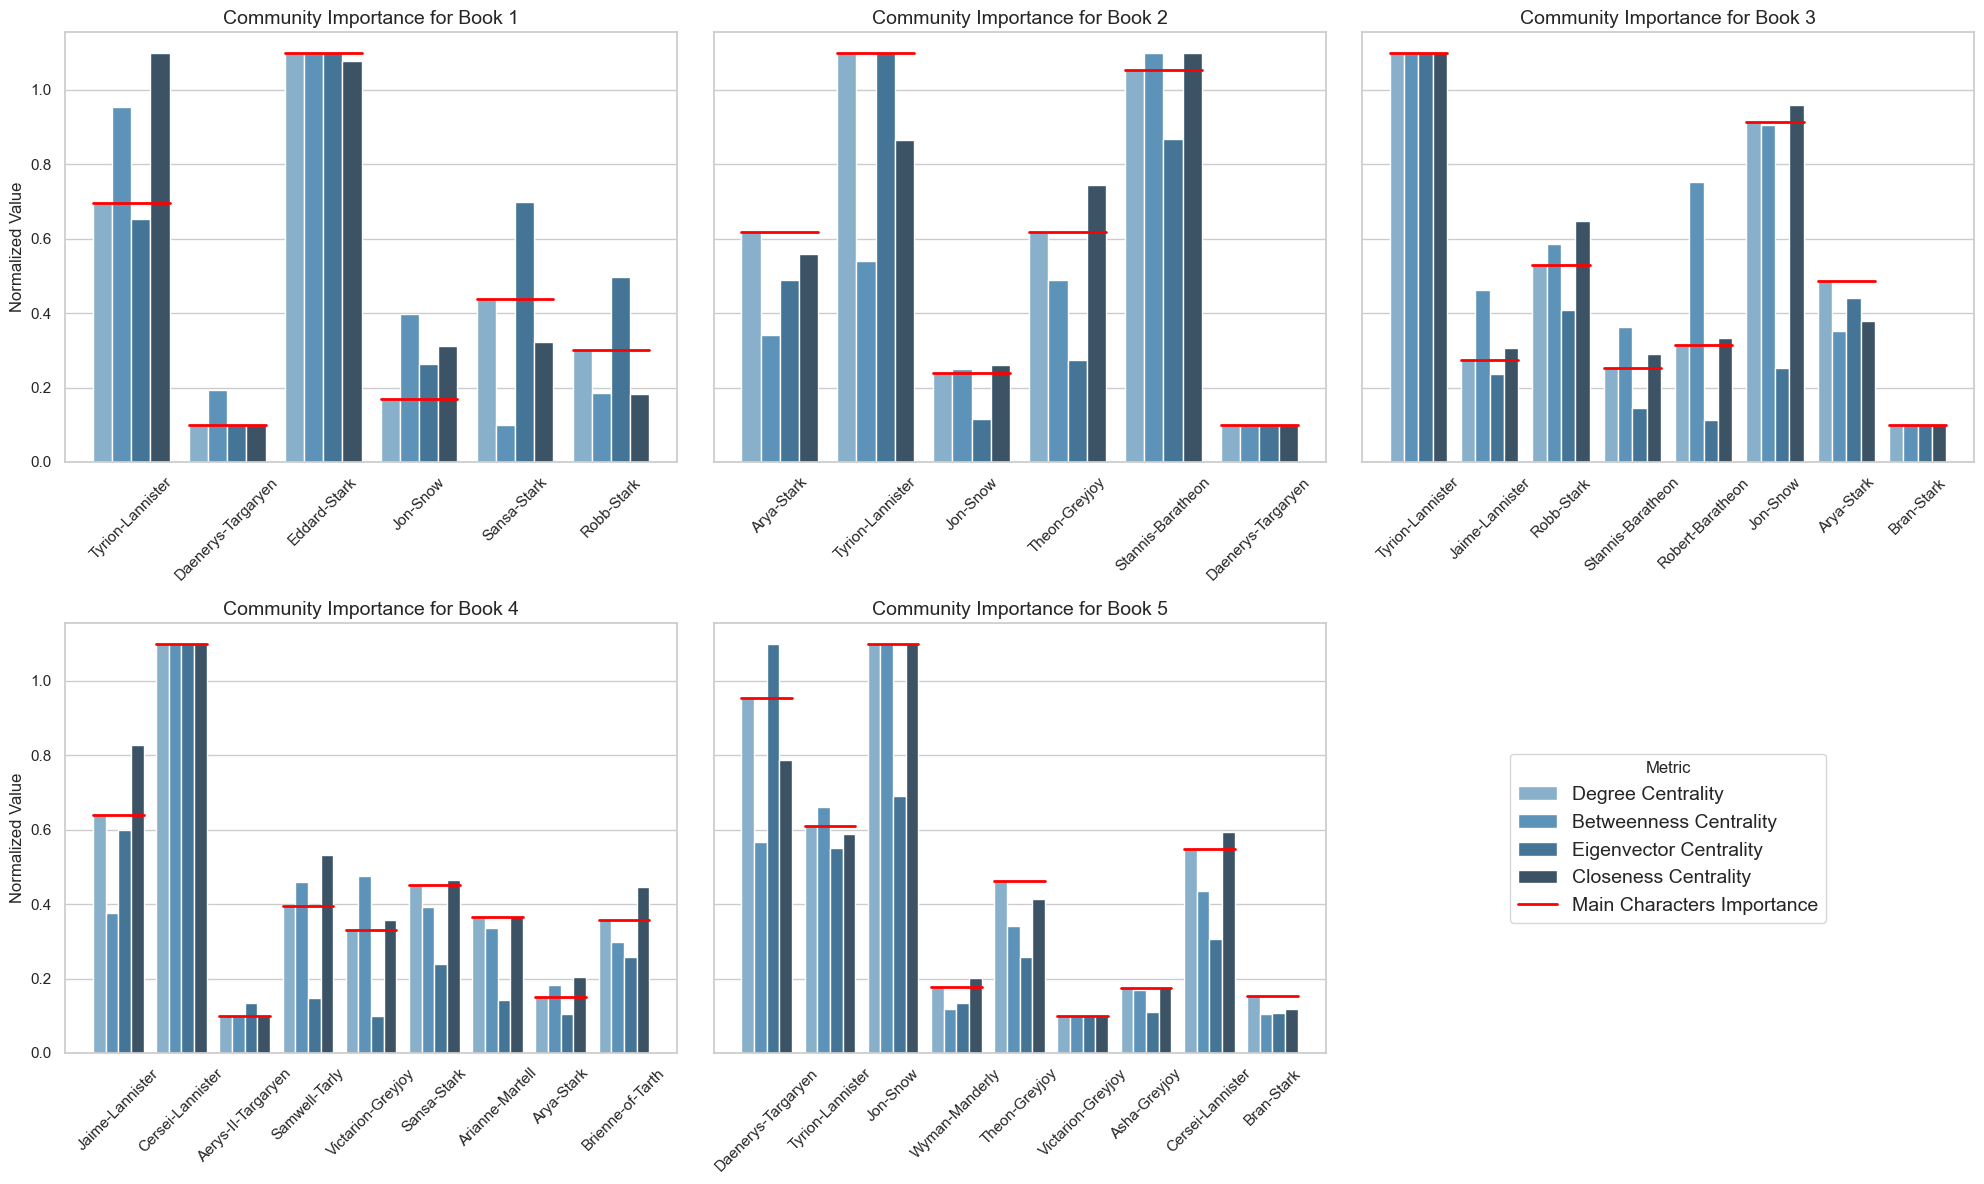

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.lines as mlines

# 设置Seaborn的主题
sns.set_theme(style="whitegrid")

# 设置图形大小和布局
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=True)
axes = axes.flatten()

# 中心性指标
metrics = ['Degree Centrality', 'Betweenness Centrality', 'Eigenvector Centrality', 'Closeness Centrality']

# 初始化标准化器
scaler = MinMaxScaler()

# 绘制每本书的社区重要性图
for i, book_id in enumerate(books):
    # 获取当前书的数据
    book_data = importance_df[importance_df['Book'] == book_id]
    
    # 对每个指标进行标准化
    book_data[metrics] = scaler.fit_transform(book_data[metrics])
    leader_importance = scaler.fit_transform(book_data[['Degree Centrality']])
    
    # 平移数据，避免出现0值
    book_data[metrics] += 0.1
    leader_importance += 0.1
    
    # 将数据转换为长格式
    book_data_long = book_data.melt(id_vars=['Community', 'Leader'], value_vars=metrics, var_name='Metric', value_name='Value')
    
    # 绘制条形图
    sns.barplot(
        x='Leader', 
        y='Value', 
        hue='Metric', 
        data=book_data_long, 
        ax=axes[i],
        palette="Blues_d"  # 设置颜色主题
    )
    
    # 添加社区leader的重要性（度中心性）红色实线
    for j, leader in enumerate(book_data['Leader']):
        leader_value = leader_importance[j][0]
        axes[i].plot([j - 0.4, j + 0.4], [leader_value, leader_value], color='red', linewidth=2)
    
    # 设置标题和标签
    axes[i].set_title(f'Community Importance for Book {book_id}', fontsize=14)
    axes[i].set_xlabel('')  # 仅在最后一行显示X轴标签
    axes[i].set_ylabel('Normalized Value', fontsize=12)
    
    # 旋转横坐标标签
    axes[i].tick_params(axis='x', rotation=45)
    
    # 移除子图中的图例
    axes[i].get_legend().remove()

# 添加统一的图例
handles, labels = axes[0].get_legend_handles_labels()
# 添加红色实线的图例项
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Leader Importance')
handles.append(red_line)
labels.append('Main Characters Importance')

# 将图例放置在第六个子图位置
axes[-1].legend(handles, labels, title='Metric', loc='center', fontsize=14)
axes[-1].axis('off')  # 隐藏第六个子图的坐标轴

# 移除多余的子图
for j in range(len(books), len(axes) - 1):
    fig.delaxes(axes[j])

# 调整布局
plt.tight_layout()
plt.show()
